In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 선형회귀모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환->표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse
import matplotlib
# 패키지 불러오기
from sklearn.linear_model import Ridge, Lasso, ElasticNet
#from sklearn.tree import export_graphviz  환경 설정하기 어려움
#import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# 나무 구조 시각화  
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

In [4]:
matplotlib.rc('font', family = 'Malgun Gothic') 

# 의사결정나무_예측(콘크리트)

In [61]:
df_raw = pd.read_csv("C:/Users/USER/Desktop/포스코 청년 아카데미_B4_김민경/데이터 분석1/분석자료/Concrete.CSV")
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [62]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['strength']
df_raw_x = df_raw.drop('strength', axis = 1, inplace = False)

In [63]:
# train, test 분리 6:4 비율로 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                               test_size= 0.4, random_state=1234)
print('train data X size : {}'.format(df_train_x.shape))
print('train data Y size : {}'.format(df_train_y.shape))
print('test data X size : {}'.format(df_test_x.shape))
print('test data Y size : {}'.format(df_test_y.shape))

train data X size : (618, 8)
train data Y size : (618,)
test data X size : (412, 8)
test data Y size : (412,)


In [68]:
# 기본 옵션으로 모델을 생성한다.
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 설명력
print('Score on training set : {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print('Score on test set : {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

# 모델 설명력은 train 은 99.6% , test는 79% 로 모델 설명력은 좋아보이지만 train 데이터에 과적합이 보인다.

Score on training set : 0.996
Score on test set : 0.790


In [69]:
train_score =[]
test_score=[]

#para_leaf는 [1, 2, 3~ ~ 19]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234
                                , min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


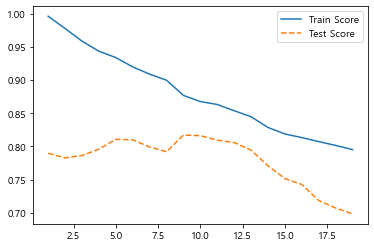

In [70]:
# 모델 설몀력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

# 잎사귀 노드 최소 자료수는 6과 9로 설정하겠다
# train과 test 데이터의 성능 변화를 고려하여 10과 27을 선택
# 다만 27을 선택할 시 train 데이터의 성능이 많이 저하된다.

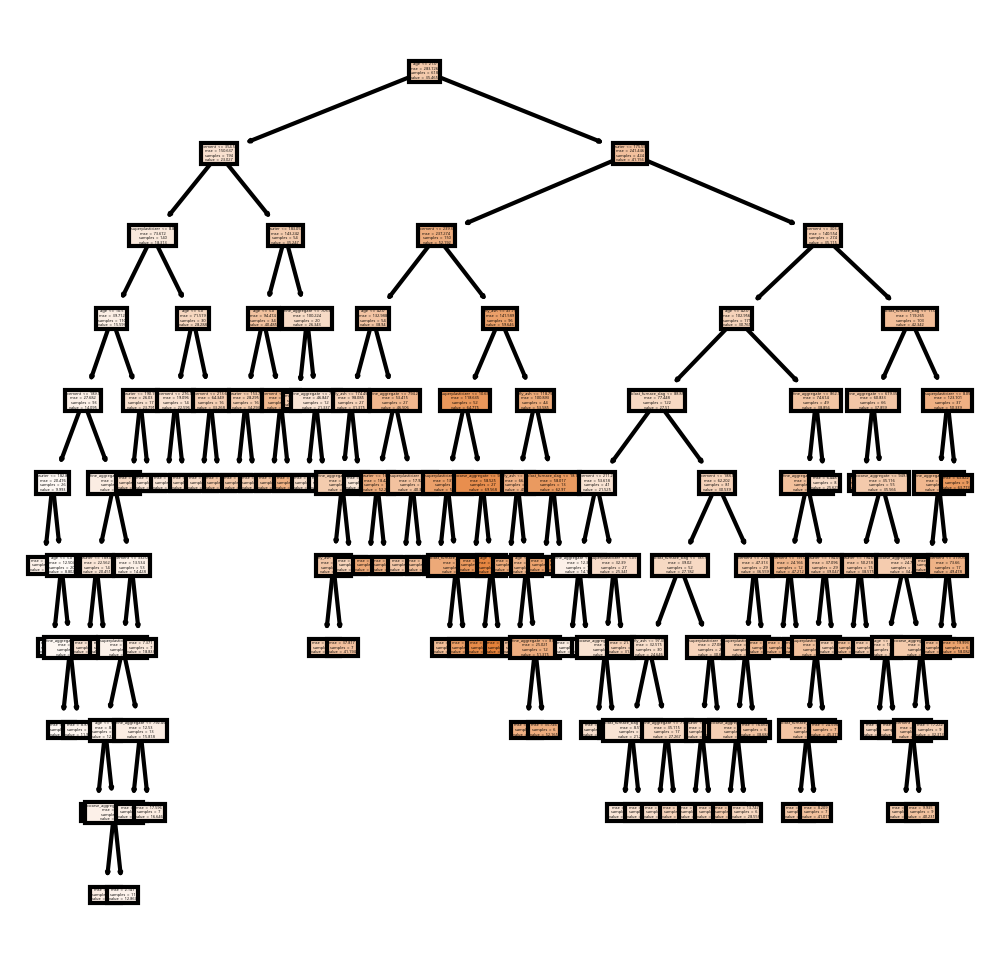

In [71]:
# 변수명 저장
v_feature_name = df_train_x.columns
# 노드의 최소 자료 수=6 모델
tree_graph = DecisionTreeRegressor(random_state=1234,  min_samples_leaf=6)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

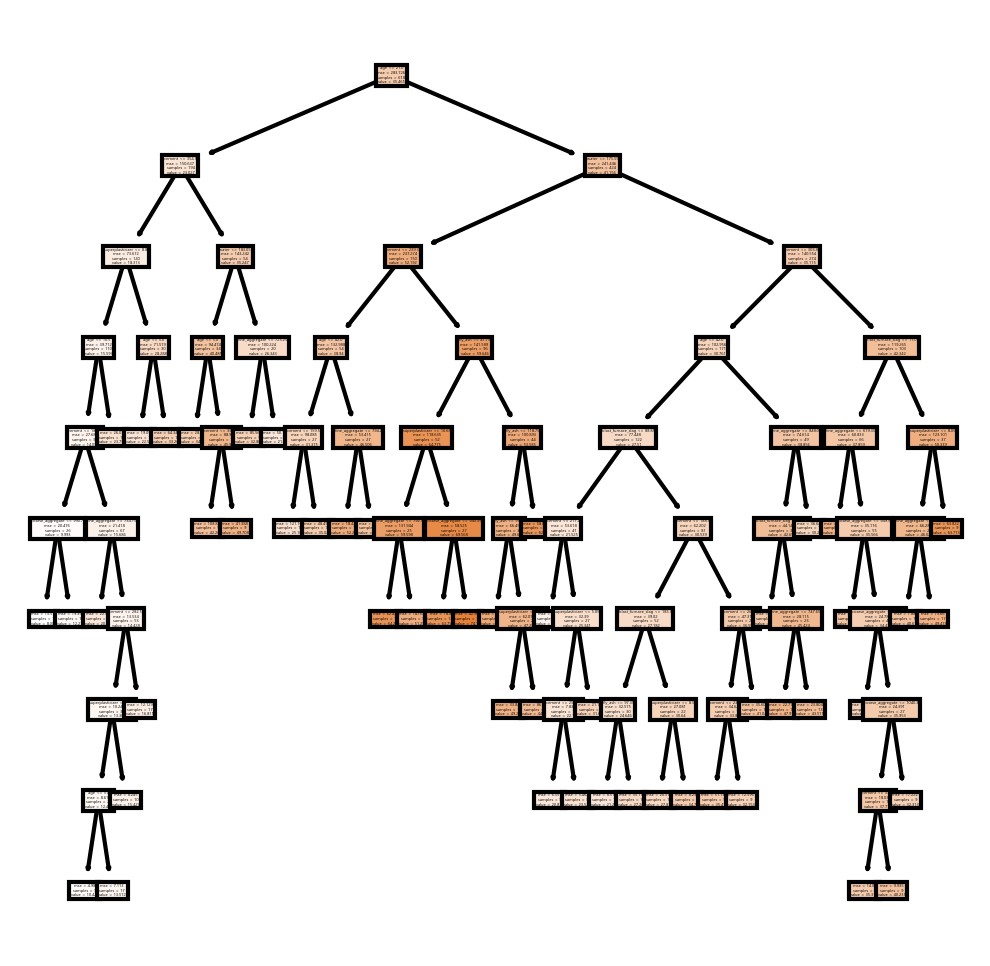

In [72]:
# 노드의 최소 자료 수=16 모델
tree_graph = DecisionTreeRegressor(random_state=1234,  min_samples_leaf=9 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

잎사귀 노드 최소 자료수가 증가함에 따라 모델의 설명력은 감소하며 과적합 가능성이 높으므로  min_samples_leaf=6 으로 고정한다.

In [73]:
train_score = [] 
test_score = []
# min_samples_split: 분리 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6
                                 , min_samples_split=v_min_samples_split )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.920,0.810
1,6,0.920,0.810
2,8,0.920,0.810
3,10,0.920,0.810
4,12,0.920,0.810
5,14,0.914,0.806
6,16,0.910,0.799
7,18,0.893,0.800
8,20,0.889,0.803
9,22,0.879,0.801


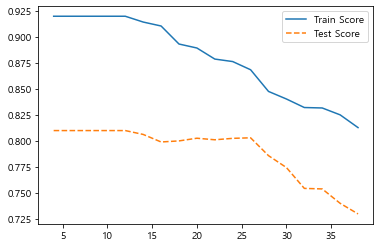

In [74]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.legend()

# 성능변화를 고려하여 20, 26 선택

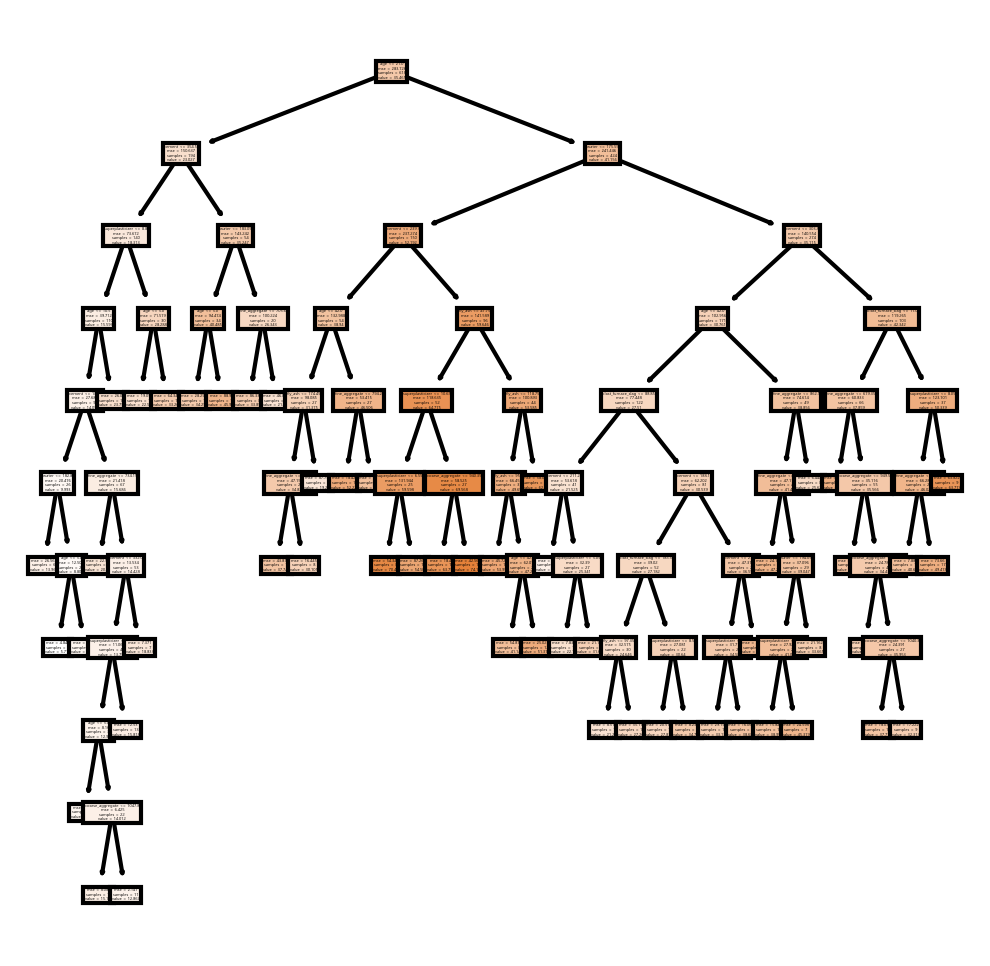

In [75]:
# 분리노드의 최소자료수 = 20 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6, min_samples_split=20 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

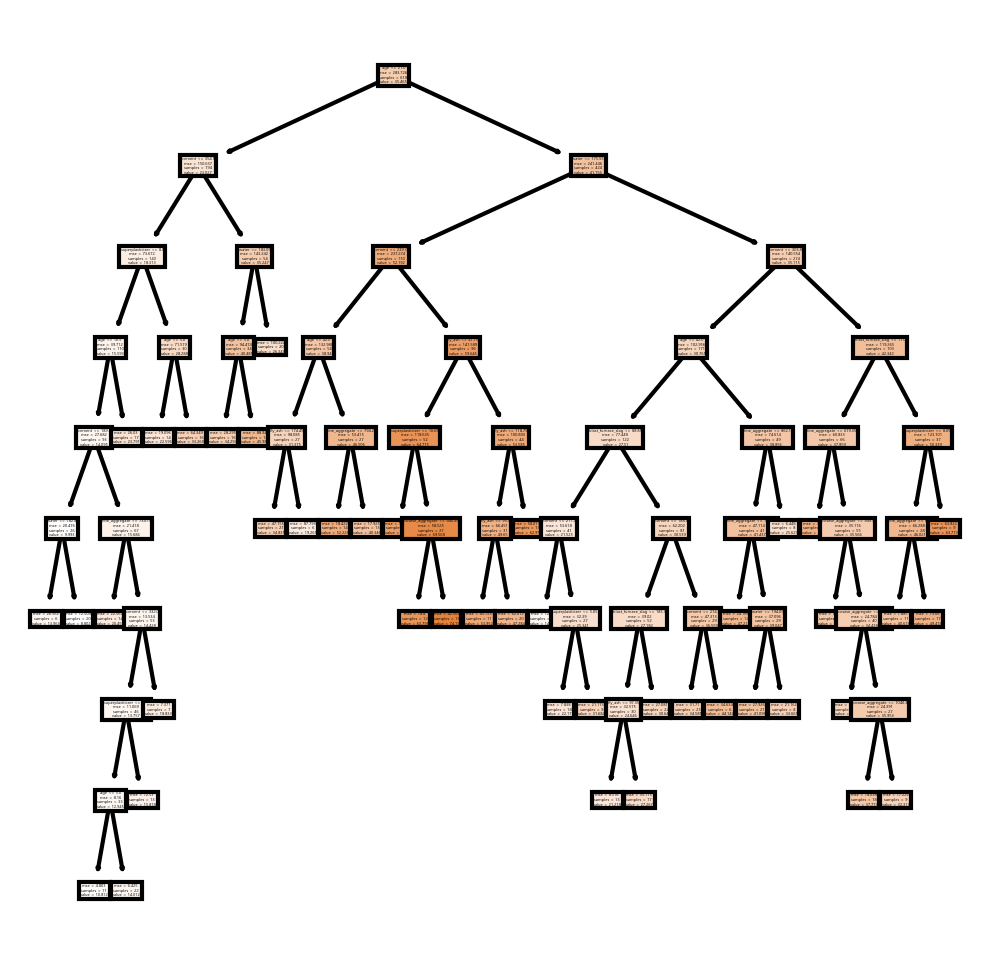

In [76]:
# 분리노드의 최소자료수 = 20 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6, min_samples_split=26 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

분리노드의 최소 자료수가 증가함에 따라 모델의 설명력은 감소하며 과적합 가능성이 높으므로  min_samples_leaf=20 으로 고정한다.

In [78]:
train_score = []
test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6, min_samples_split=20
                                  , max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.249,0.243
1,2,0.474,0.406
2,3,0.644,0.567
3,4,0.749,0.680
4,5,0.825,0.734
5,6,0.867,0.791
6,7,0.882,0.804
7,8,0.889,0.802
8,9,0.889,0.803
9,10,0.889,0.803


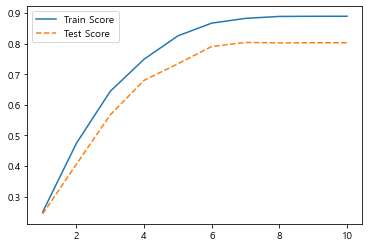

In [79]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.legend()

# train / test 데이터의 성능을 고려하여 4와 6으로 선택

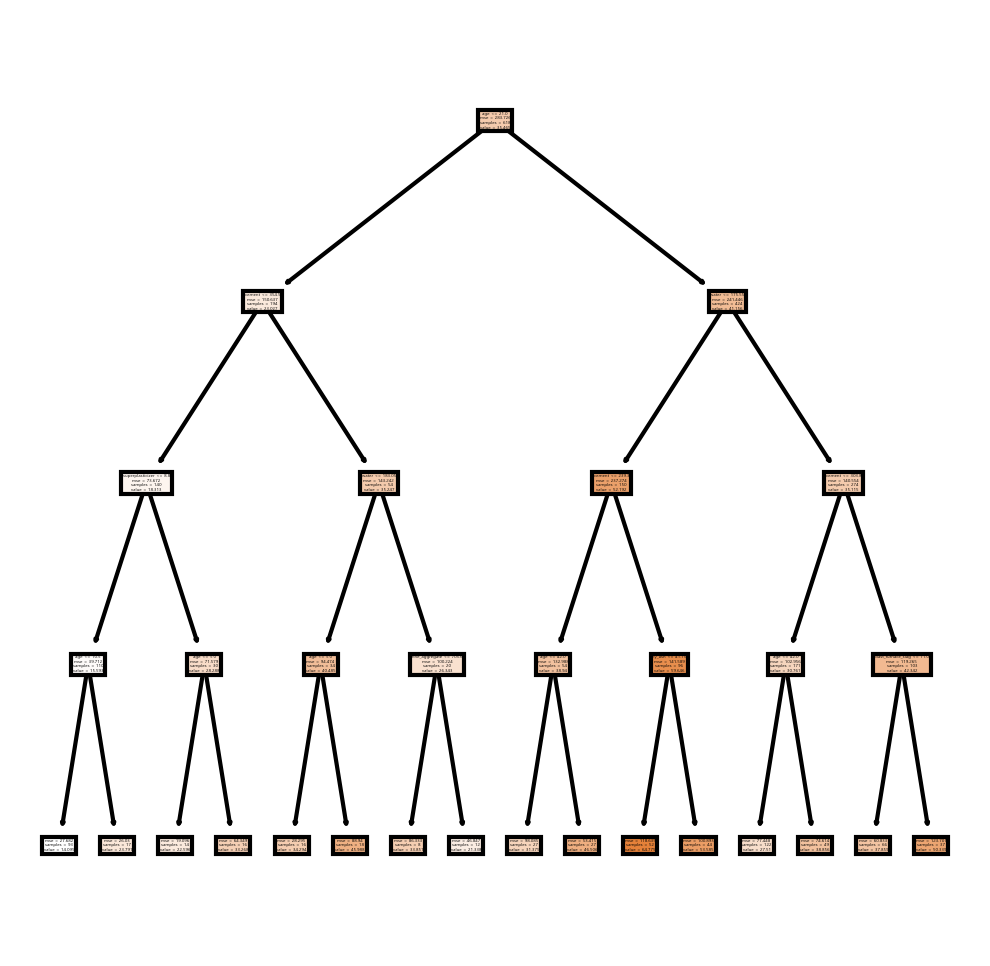

In [80]:
# 최대깊이 = 2 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6, min_samples_split=20, max_depth = 4 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

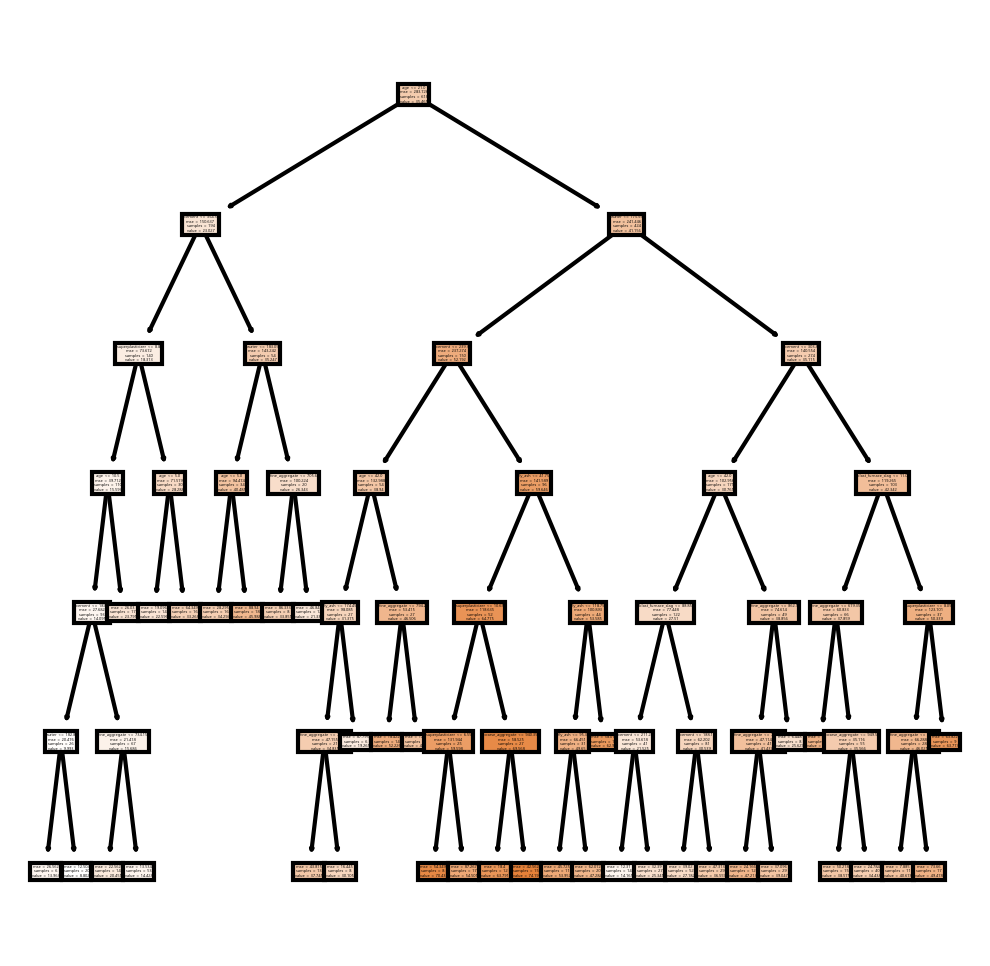

In [81]:
# 최대깊이 = 2 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6, min_samples_split=20, max_depth = 6 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

최대 깊이는 깊어질수록 과적합이 되고, 최대깊이가 4일때 균형적이므로 최대깊이는 4로 고정한다.

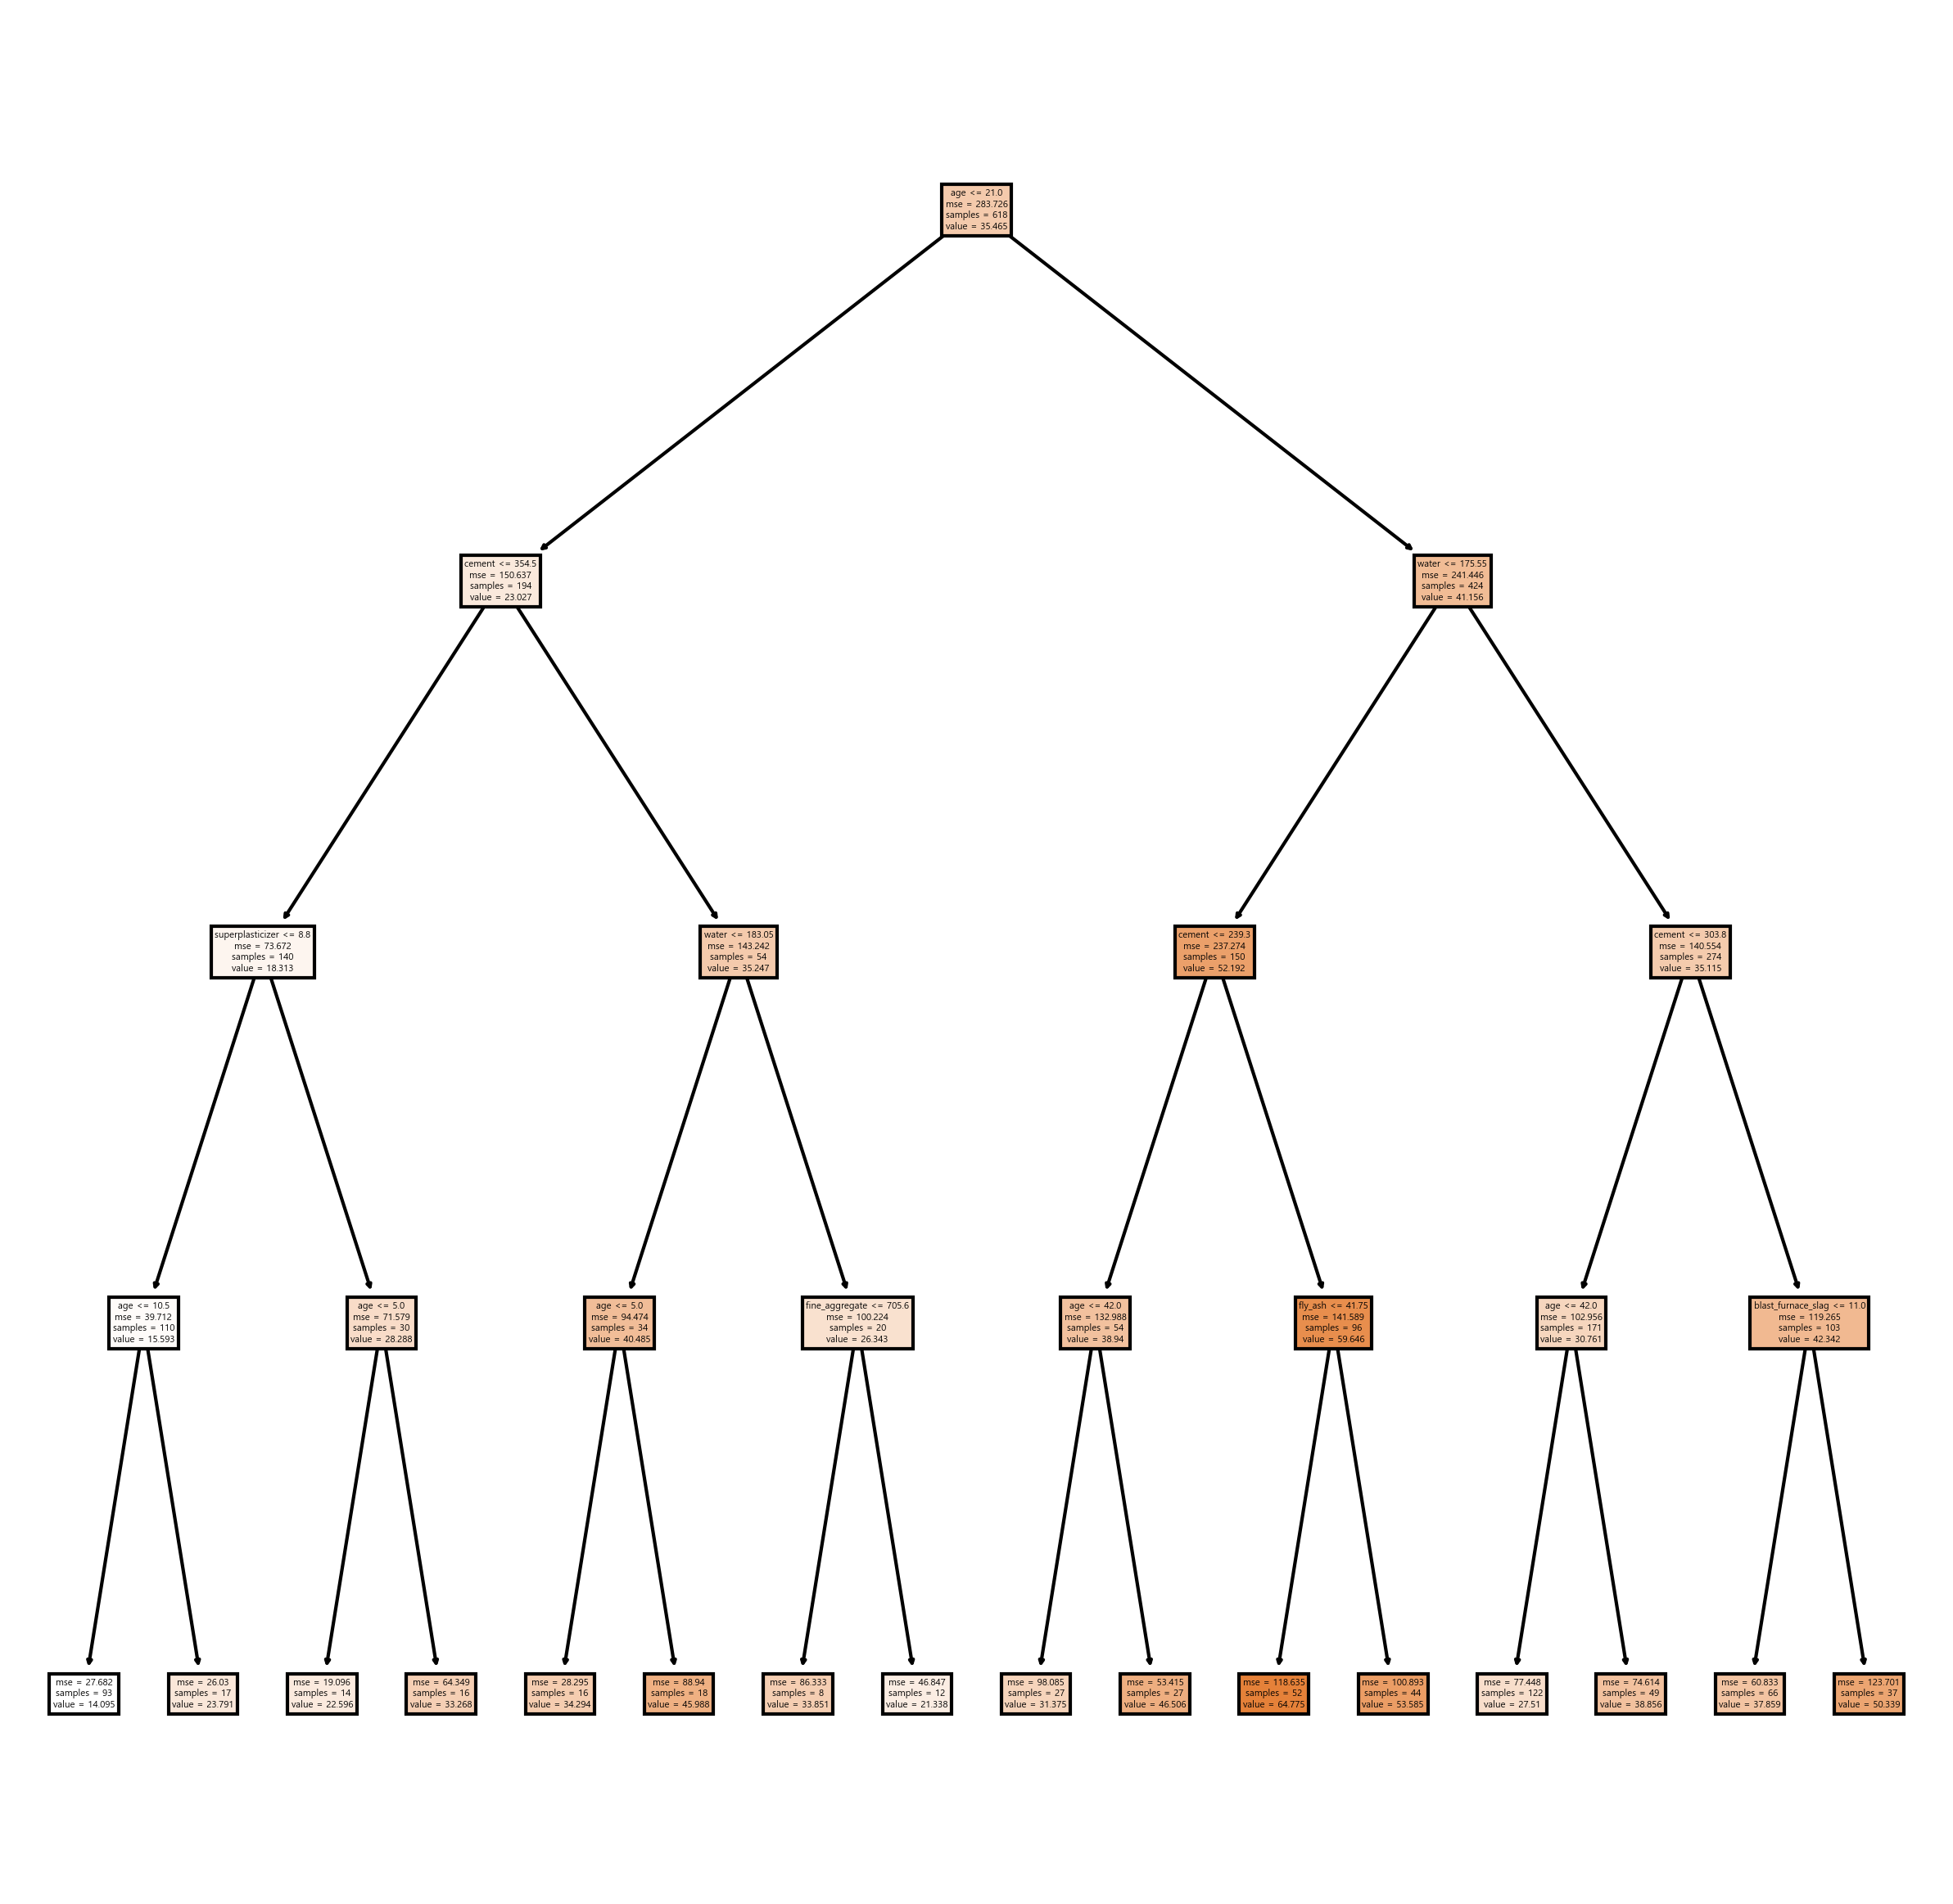

In [88]:
# 최종 모델
tree_final = DecisionTreeRegressor(min_samples_leaf = 6, min_samples_split = 20, max_depth = 4, random_state=1234, )
tree_final.fit(df_train_x, df_train_y)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10, 10), dpi=300)
plot_tree(tree_final, feature_names = v_feature_name, filled = True);


In [84]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

# age : 재령 - 재료가 제작된 때로부터의 경과 일수를 의미한다.

,Feature,Importance
7,age,0.416
0,cement,0.264
3,water,0.234
4,superplasticizer,0.029
1,blast_furnace_slag,0.028
2,fly_ash,0.023
6,fine_aggregate,0.006
5,coarse_aggregate,0.000


트리를 해석하면

age가 21 보다 작으면 mse는 감소하며 강도가 줄어드고 21보다 크면 mse가 감소하고 강도는 증가한다.

시멘트가 354,5 보다 감소하면 강도는 약해지고 354.5 보다 크면 강도가 커진다

수분(water)이 175보다 적으면 강도는 증가하고 175보다 커지면 강도는 감소한다 

유동화제 (superplasticizer)가 8.8보다 작으면 강도가 줄어들고 8.8보다 크면 강도가 세진다.
최대 깊이가 증가하면서 생성되는 이파귀의 자료수는 감소하고  대체적으로 mse가 감소한다 

Text(0, 0.5, '변수')

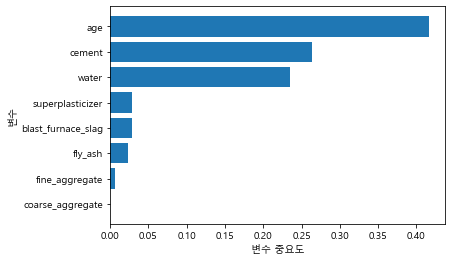

In [89]:
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

age, cement, water, superplasticizer순으로 중요도가 크다
즉 age, cement, water순으로 강도에 영향을 많이 준다고 해석할 수 있다. 

단, 계산된 변수 중요도 값이 낮거나 0이여도 선택되는 데이터에 따라서 중요도가 변경될 수 있다.

In [28]:
# GridSearchCV를 이용한 최적 parameter 찾기
estimator = DecisionTreeRegressor()
# 구하고자 하는 parameter와 범위
param_grid = {"criterion": ["mse", "friedman_mse", "mae"], "max_features": ["auto", "sqrt", "log2"],
              "max_depth": para_depth, "min_samples_split": para_split,
              "min_samples_leaf": para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_tra foin_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      max_features='auto', min_samples_leaf=3,
                      min_samples_split=6)

best parameter: 
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6}

best score: 
0.793


최대 깊이가 10, 잎사귀의 최소샘플수 3, 분리 노드의 최소자료수가 6 일때 설명력이 79.3% 이다

# 랜덤 포레스트_예측 ( 콘크리트)

In [5]:
df_raw = pd.read_csv("C:/Users/USER/Desktop/포스코 청년 아카데미_B4_김민경/데이터 분석1/분석자료/Concrete.CSV")
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [6]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['strength']
df_raw_x = df_raw.drop('strength', axis = 1, inplace = False)

In [7]:
# train, test 분리 6:4 비율로 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                               test_size= 0.4, random_state=1234)
print('train data X size : {}'.format(df_train_x.shape))
print('train data Y size : {}'.format(df_train_y.shape))
print('test data X size : {}'.format(df_test_x.shape))
print('test data Y size : {}'.format(df_test_y.shape))

train data X size : (618, 8)
train data Y size : (618,)
test data X size : (412, 8)
test data Y size : (412,)


In [11]:
rf_uncustomized = RandomForestRegressor(random_state = 1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 설명력
print('Score on training set : {:.3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print('Score on test set : {:.3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

# train 98%, test 90.4 프로이다. train데이터에 과적합이 보인다.

Score on training set : 0.980
Score on test set : 0.904


In [12]:
train_score =[]
test_score=[]

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(random_state = 1234,n_estimators =v_n_estimators )
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.973,0.905
1,20,0.978,0.905
2,30,0.979,0.903
3,40,0.979,0.905
4,50,0.980,0.905
5,60,0.980,0.906
6,70,0.980,0.906
7,80,0.980,0.906
8,90,0.980,0.905
9,100,0.980,0.904


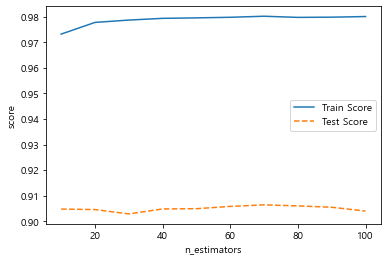

In [13]:
# 모델 설몀력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

# 트리의 수가 60개를 초과해도 설명력은 그대로 이기에 트리의 수는 60개로 고정한다.

In [14]:
# 잎사귀 노드의 최소자료수 변경에 따른 모델 성능
train_score =[]
test_score=[]

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf =RandomForestRegressor(random_state = 1234,n_estimators =60,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.980,0.906
1,2,0.967,0.900
2,3,0.952,0.892
3,4,0.939,0.880
4,5,0.925,0.871
5,6,0.913,0.859
6,7,0.903,0.851
7,8,0.895,0.846
8,9,0.886,0.837
9,10,0.877,0.825


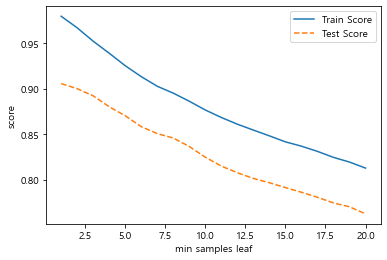

In [15]:
# 모델 설몀력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('min samples leaf')
plt.legend()

# 잎사귀 노드의 최소 자료수 증가에 따라서 모델의 설명력은 감소하므로 8로 선택.

In [16]:
# 분리노드의 최소자료수 변경에 따른 모델 성능
train_score = [] 
test_score = []
# min_samples_split: 분리 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, min_samples_leaf=8,
                         n_estimators =60, min_samples_split=v_min_samples_split )
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.895,0.846
1,6,0.895,0.846
2,8,0.895,0.846
3,10,0.895,0.846
4,12,0.895,0.846
5,14,0.895,0.846
6,16,0.895,0.846
7,18,0.891,0.841
8,20,0.885,0.834
9,22,0.880,0.828


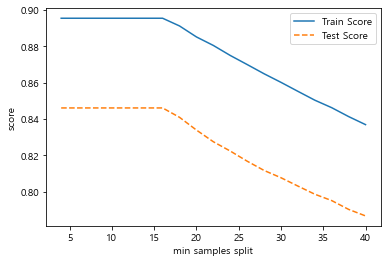

In [17]:
# 모델 설몀력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel('score')
plt.xlabel('min samples split')
plt.legend()

# 분리 노드의 최소 자료수 증가에 따라 모델의 설명력은 감소하므로 train ,test 데이터의 성능을 고려하여 16으로 선택.

In [18]:
# 최대 깊이 변경에 따른 모델 성능
train_score = []
test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, min_samples_leaf=8, min_samples_split=16
                                  , max_depth = v_max_depth,n_estimators =60)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.336,0.327
1,2,0.612,0.592
2,3,0.738,0.694
3,4,0.811,0.768
4,5,0.863,0.819
5,6,0.884,0.839
6,7,0.892,0.844
7,8,0.895,0.846
8,9,0.895,0.846
9,10,0.895,0.846


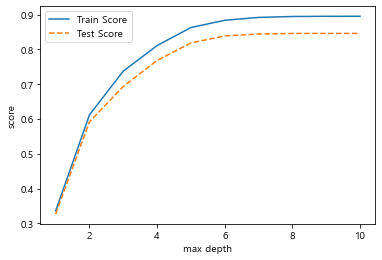

In [19]:
# 모델 설몀력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

# 최대 깊이가 증가에 따라서 모델의 설명력은 증가하므로 3으로 선택.

In [23]:
# 최대 깊이를 3으로 했을 때
rf_final = RandomForestRegressor(min_samples_leaf = 8, min_samples_split = 16, max_depth = 3, random_state=1234,
                                n_estimators =60)
rf_final.fit(df_train_x, df_train_y)

# train 데이터 설명력
print('Score on training set : {:.3f}'.format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print('Score on test set : {:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

Score on training set : 0.738
Score on test set : 0.694


train 73.8%, test 69.4%로 과적합이 줄었들었으며 모델의성능이 좋다고 해석할 수 있다.

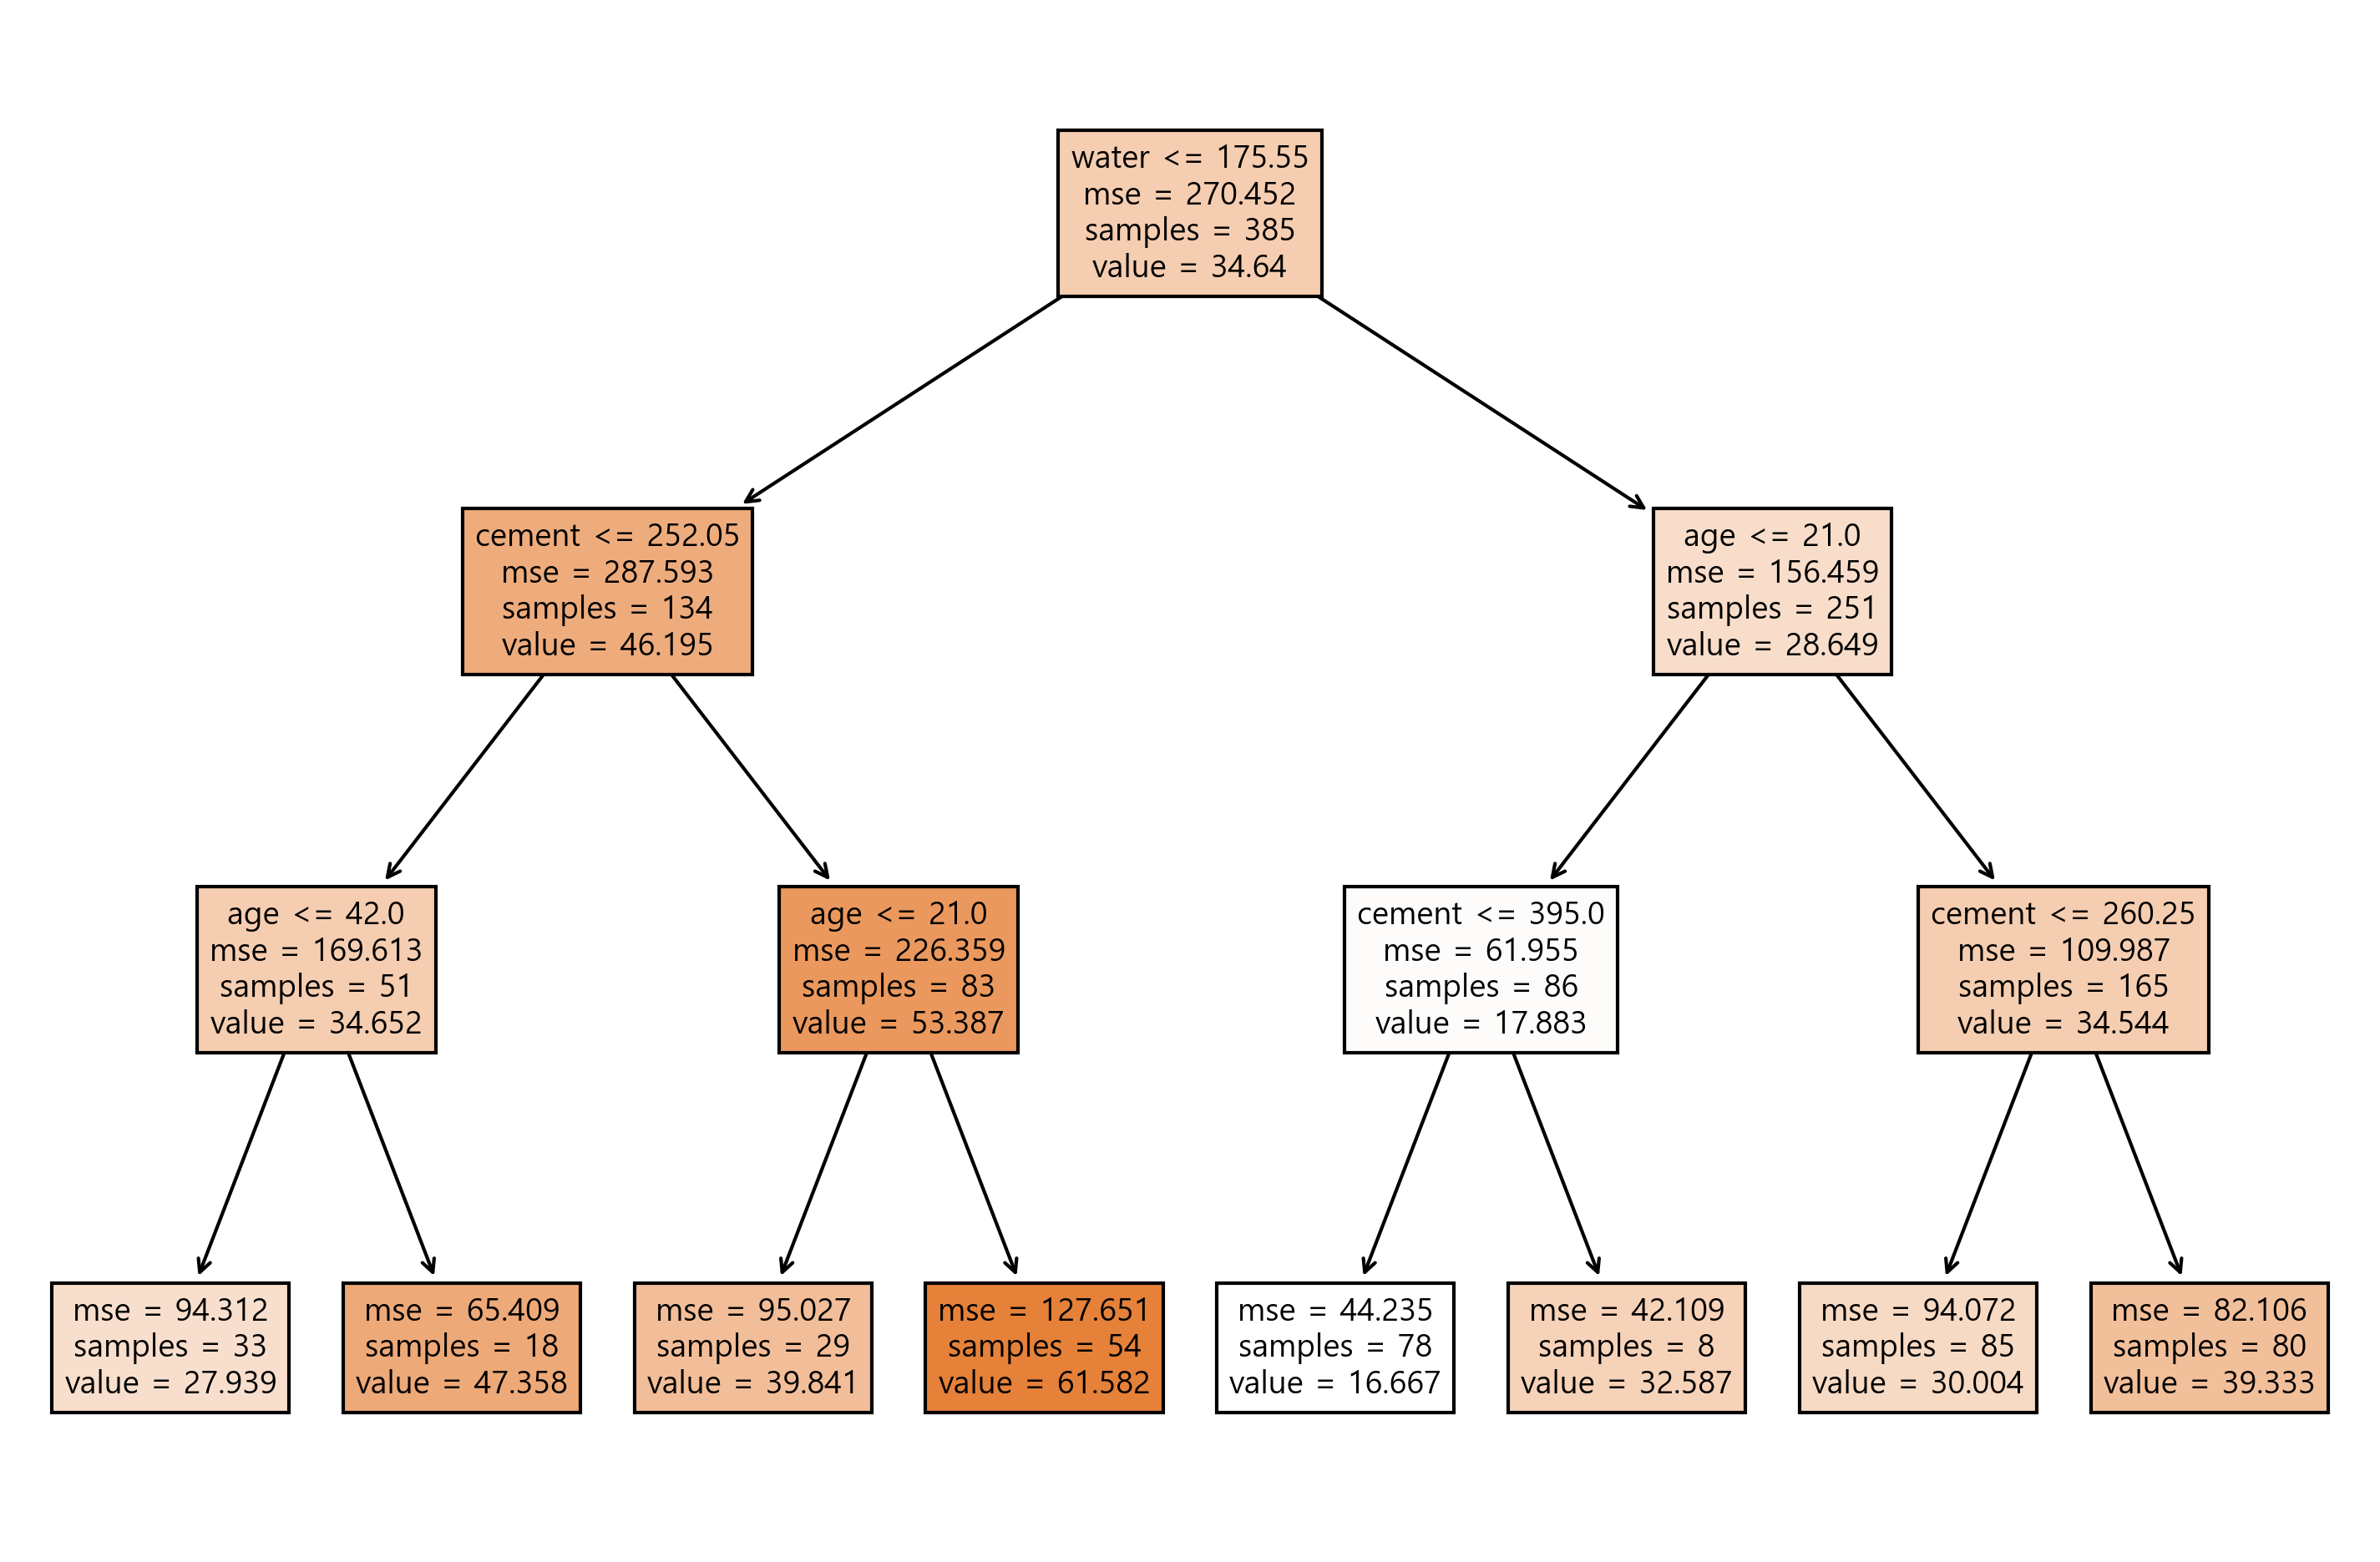

In [24]:
# 최종 모델 시각화
# 변수명 저장
v_feature_name = df_train_x.columns
# 1번 트리
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12, 8), dpi=300)
plot_tree(rf_final.estimators_[1], feature_names = v_feature_name, filled = True);

In [25]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.445
0,cement,0.299
3,water,0.167
4,superplasticizer,0.076
6,fine_aggregate,0.005
1,blast_furnace_slag,0.004
5,coarse_aggregate,0.003
2,fly_ash,0.002


Text(0, 0.5, '변수')

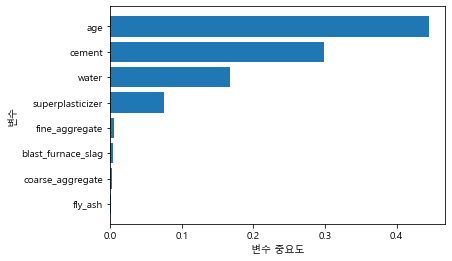

In [26]:
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

age, cement, water, superplasticizer순으로 중요도가 크다
즉 age, cement, water순으로 강도에 영향을 많이 준다고 해석할 수 있다. 

의사결정나무로 예측했을때와 비교를 해보면 중요도의 전반적인 방향은 비슷하지만 수분(water)의 중요도는 줄어들었고 유동화제(superplasticizer)의 중요도는 증가하였다

단, 계산된 변수 중요도 값이 낮거나 0이여도 선택되는 데이터에 따라서 중요도가 변경될 수 있다.

최적 파마리터 찾기는 저의 노트북에서 너무 시간이 오래걸려서 건너뛰었습니다.